# 0.0 Imports

In [1]:
import pandas as pd
import math
import inflection
import numpy as np
import seaborn as sns
import datetime as dtt
import xgboost as xgb
import random
import warnings
import pickle
import json
import requests

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

## 0.1. Helper functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error (y, yhat):
    return np.mean(np.abs((y - yhat)/y))
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y , yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'model name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number{}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - dtt.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - dtt.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & 
                                (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name, 
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str) , 
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str), 
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                         index=[0])




## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('Datasets_ds/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Datasets_ds/store.csv', low_memory=False)

#merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

## 1.0 Descricao dos dados

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.1 Rename columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#Rename
df1.columns = cols_new

# 1.2 Data Dimensions

In [7]:
print('number of rows {}'.format(df1.shape[0]))
print('number of cols {}'.format(df1.shape[1]))

number of rows 1017209
number of cols 18


# 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
print(df1.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object


# 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA

In [10]:
#competition_distance             
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1) 

#competition_open_since_year     

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1) 

#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)
                 
#promo_interval
df1['promo_interval'].fillna(0, inplace=True)

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

# 1.6 Change dtypes

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['promo2'].sample

<bound method NDFrame.sample of 0          0
1          1
2          1
3          0
4          0
          ..
1017204    1
1017205    0
1017206    0
1017207    0
1017208    1
Name: promo2, Length: 1017209, dtype: int64>

# 1.7 Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [17]:
# Numerical Attributes
# Tendencia central


# '.T' é um 'transpose', nao entendi direito pra que serve (deve ser pra visualizar a tabela deitada, acho q eh isso)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersao
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(min)).T
#range
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d3, d2, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,standard_deviation,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='customers', ylabel='Density'>

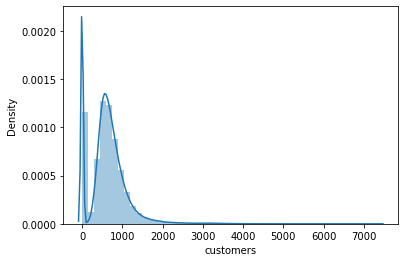

In [18]:
sns.distplot(df1['customers'])

In [19]:
# Categorical Attributes


In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

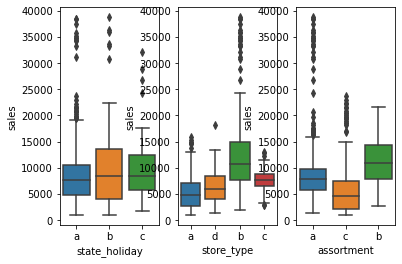

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday',y='sales', data=aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type',y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment',y='sales', data=aux1)


# 2.0 Feature Engineering

In [22]:
df2 = df1.copy()

## 2.1 Criacao de Hipoteses

### 2.1.1 Hipoteses da loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores proximos a mais tempo deveriam vender mais

### 2.1.2 Hipoteses do produto

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expoe mais os produtos na vitrine deveriam vender mais

**3.** Lojas que tem preços menores deveriam vender mais

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**6.** Lojas com promocoes consecutivas deveriam vender mais

### 2.1.3 Hipoteses temporais

**1.** Lojas que fecham mais em feriados deveriam vender menos

**2.** Lojas que abrem nos finais de semana deveriam vender mais

**3.** Lojas deveriam vender mais ao longo dos anos

**4.** Lojas deveriam vender mais no segundo semestre dos anos

**5.** Lojas deveriam vender mais depois do dia 10 de cada mes

**6.** Lojas deveriam vender mais no segundo semestre dos anos

**7.** Lojas deveriam vender menos em feriados escolares

## 2.2 Lista final de Hipoteses

### o criterio utilizado foi se eu ja tenho esse dado disponivel na minha base de dados

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores proximos a mais tempo deveriam vender mais

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**5.** Lojas com promocoes consecutivas deveriam vender mais

**6.** Lojas que fecham mais em feriados deveriam vender menos

**7.** Lojas que abrem nos finais de semana deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre dos anos

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes

**11.** Lojas deveriam vender mais no segundo semestre dos anos

**12.** Lojas deveriam vender menos em feriados escolares

## 2.3 Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: dtt.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: dtt.datetime.strptime(x + '-1', '%Y-%W-%w') - dtt.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [99]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 Filtragem de Variaveis

In [25]:
df3 = df2.copy()

In [26]:
df3.head()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [29]:
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria dos Dados - EDA

In [30]:
df4 = df3.copy()

## 4.1 Analise univariada

### 4.1.1 Response variable

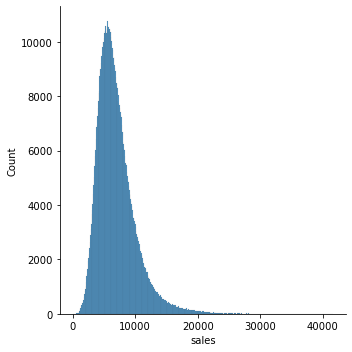

In [31]:
sns.displot(df4['sales'])

### 4.1.2 Numerical variables

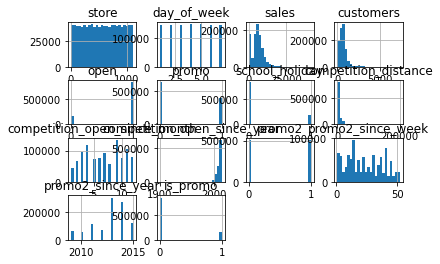

In [32]:
#plt.subplot(5, 3, 1)
#num_attributes['store'].hist(bins=25);
#plt.subplot(5, 3, 2)
#plt.subplot(5, 3, 3)
#plt.subplot(5, 3, 4)
#plt.subplot(5, 3, 5)
#plt.subplot(5, 3, 6)
#plt.subplot(5, 3, 7)
#plt.subplot(5, 3, 8)
#plt.subplot(5, 3, 9)
#plt.subplot(5, 3, 10)
#plt.subplot(5, 3, 11)
#plt.subplot(5, 3, 12)
#plt.subplot(5, 3, 13)
#plt.subplot(5, 3, 14)

num_attributes.hist(bins=25);


### 4.1.3 Categorical variables

In [33]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424            easter
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

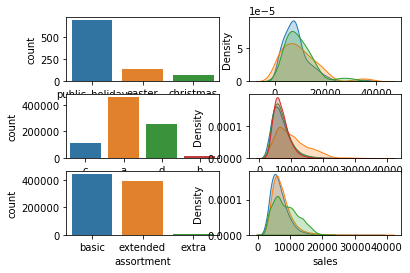

In [34]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] !='regular_day'] 
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)

sns.kdeplot(df4[df4['state_holiday'] == 'easter']['sales'], label='easter', shade=True)

sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)

sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)

sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)

sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assortment

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)

sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Analise bivariada

**1.** Lojas com maior sortimento deveriam vender mais

**FALSA**

essa hipotese é falsa, lojas com maior sortimento vendem menos (isso oq o meigarom falou, mas eu acho que a gente deveria ver as lojas com maior sortimento PROPORCIONALMENTE, pois existem bem menos lojas extra doq as outras, entao logico que vai acontecer isso

In [35]:
df4[['assortment','date']].groupby('assortment').count()

,date
assortment,
basic,444875
extended,391254
extra,8209


<AxesSubplot:xlabel='year_week'>

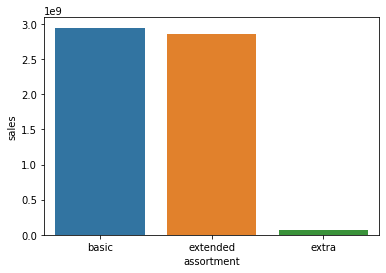

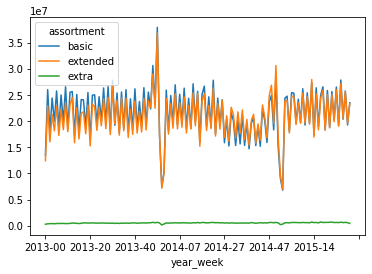

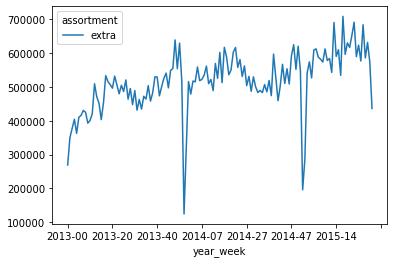

In [36]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()



**2.** Lojas com competidores mais proximos deveriam vender menos

**FALSE**

<AxesSubplot:>

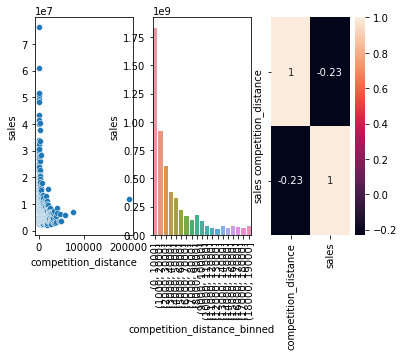

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


**3.** Lojas com competidores proximos a mais tempo deveriam vender mais

**FALSA**

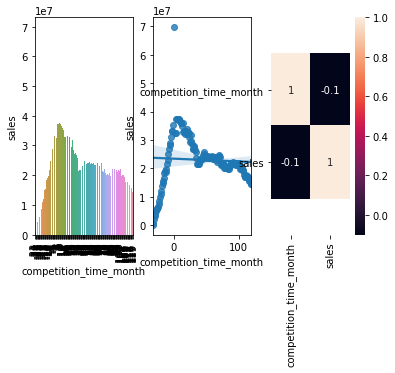

In [38]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']< 120) &(aux1['competition_time_month'] != 0)]

sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);


plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)

x = sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais

**FALSA**

<AxesSubplot:xlabel='promo_time_week', ylabel='sales'>

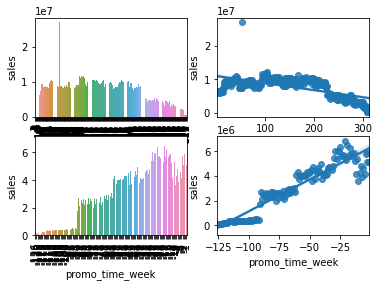

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week', y='sales', data=aux1);


plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);


plt.subplot(2, 2, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)


plt.subplot(2, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);


plt.subplot(2, 2, 4)
sns.regplot(x='promo_time_week', y='sales', data=aux3)



**5.** Lojas com promocoes consecutivas deveriam vender mais

**6.** Lojas que fecham mais em feriados deveriam vender menos

**7.** Lojas que abrem nos finais de semana deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre dos anos

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes

**11.** Lojas deveriam vender mais no segundo semestre dos anos

**12.** Lojas deveriam vender menos em feriados escolares

## 4.3 Analise multivariada

### 4.3.1 Numerical attributes

<AxesSubplot:>

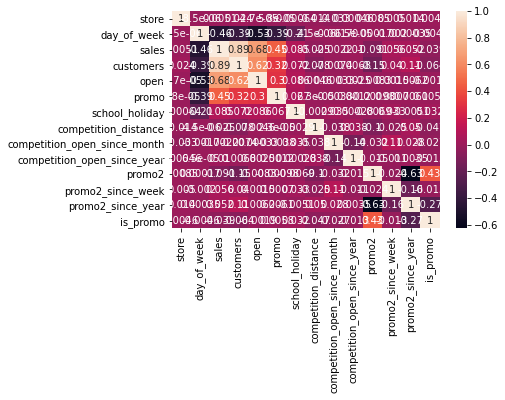

In [40]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical attributes

In [41]:
a = df4.select_dtypes(include='object')

In [42]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [43]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

<AxesSubplot:>

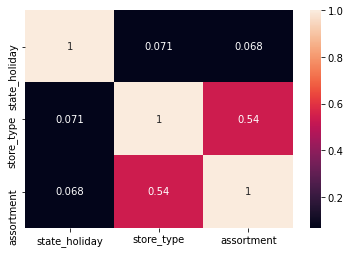

In [44]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [45]:
df5 = df4.copy()

## 5.1 Normalização

In [46]:
# nas variaveis numericas nao tinha nada com uma distribuicao normal, entao optamos por fazer apenas o reescaling


## 5.2 Rescaling

In [47]:
a = df5.select_dtypes(include=['int64', 'float64'] )

In [48]:
#muitos outliers, usar robust scaler
#sns.boxplot(data=df5['competition_distance'])

#muitos outliers, usar robust scaler
#sns.boxplot(data=df5['competition_time_month'])

#poucos outliers, usar min-max scaler
#sns.boxplot(data=df5['promo_time_week'])

In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))


# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))


## 5.3 Transformacao

### 5.3.1 Encoding

In [50]:
# state_holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
# store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - ordinal encoding
assortment_dict = {'basic': 1,
                 'extended': 3, 
                 'extra': 2}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [51]:
df5['sales'] = np.log1p(df5['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

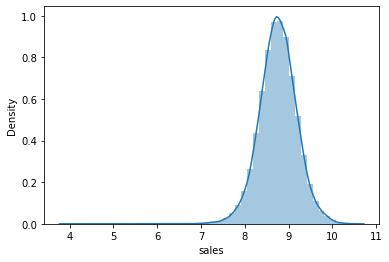

In [52]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

#### 5.3..3.1 Natureza Ciclica

In [53]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2 * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2 * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2 * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2 * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi/52 )))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi/7 )))

In [54]:
# ta so nao entendi oqq eu faço com isso daí

# 6.0 Feature Selection

In [55]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [56]:
cols_drop = ['month', 'week_of_year', 'day_of_week', 'day', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [57]:
# foi decidido arbitrariamente utilizar as ultimas 6 semanas de vendas como treino e o periodo anterior a esse,
# desde o inicio das atividades das lojas, como teste

df6[['date', 'store']].groupby('store').max().reset_index()['date'][0] - dtt.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [58]:
# x sera o df sem a variavel resposta e y o df apenas com a variavel resposta
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [59]:
# define random forest regressor
#rf = RandomForestRegressor(n_jobs=-1)

In [60]:
#training and test dataset for boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()

In [61]:
# rf -> random forest 
# n_estimators='auto' -> falar pro algoritmo escolher qual o melhor numero de arvores na hr da ramificação
# verbose=2 -> pra ver ele printando oq ele ta fazendo
# random_state=42 -> é pro algoritmo 'partir do mesmo inicio' (n entendi), pode ser qqr numero, 42 foi arbitrario

# nao pode passar um DF pra ele, tem que passar um 'vetor de numeros'

# demorou umas 2h pra rodar kkk slc
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

### 6.2.1 Best Features From Boruta

In [62]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected columns boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [63]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'week_of_year_cos',
     'week_of_year_sin',
     'day_of_week_sin',
     'day_of_week_cos']

#columns to add
feat_to_add = ['date', 'sales']

#final features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [64]:
cols_not_selected_boruta = [
     'is_promo',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'year']

In [65]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 Machine Learning Modelling

In [66]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [67]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction
# yhat é o y com acento circunflexo que é 'estimativa' em estatistica
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']


# performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,model name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression

In [68]:
# model
#lr = LinearRegression().fit(x_train, Y_train)


# prediction
#yhat_lr = lr.predict(x_test)


# performance
#lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
#lr_result

### 7.2.1 Linear regression cross validation

In [69]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
#lr_result_cv

## 7.3 Linear Regression Regularized - Lasso

In [70]:
# model
#lrr = Lasso(alpha=0.01).fit(x_train, Y_train)


# prediction
#yhat_lrr = lrr.predict(x_test)


# performance
#lrr_result = ml_error('Linear Regression Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
#lrr_result

### 7.3.1 Linear Regression Regularized Cross Validation

In [71]:
#lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Lasso', lrr, verbose=False)
#lrr_result_cv

## 7.4 Random Forest Regressor

In [72]:
# model
#n_estimators=100, numero de arvores que ele vai criar
# njobs=-1 pra ele rodar em paralelo
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)


# prediction
#yhat_rf = rf.predict(x_test)


# performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1 Random Forest Regressor Cross Validation

In [73]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=False)
#rf_result_cv

## 7.5 XGBoost Regressor

In [74]:
# model
# objective='reg:squarederror', é a funcao objetiva, pra esse caso usa essa
#eta=0.01, quantas passadas ele usa pra fazer o aprendizado
#max_depth=10, maxima profundidade, ramificaçao que a arvore pode chegar
#subsample=0.7, quantas amostras, ou qual a porcentagem de todas as variaveis que eu quero selecionar(???)
#colsample_bytree=0.9 quero "combinar" por cada uma das arvores (???)
# rodar com default, sem passar nenhum parametro
# Nataniel santos e renato da nova
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                             n_estimators=100, 
#                             eta=0.01, 
#                             max_depth=10, 
#                             subsample=0.7, 
#                             colsample_bytree=0.9).fit(x_train, Y_train)


# prediction
#yhat_xgb = model_xgb.predict(x_test)


# performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.5.1 XGBoost Regressor Cross Validation

In [75]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#xgb_result_cv

In [76]:
#=======================
#teste
#=======================

#model_xgb = xgb.XGBRegressor().fit(x_train, Y_train)


# prediction
#yhat_xgb = model_xgb.predict(x_test)


# performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
#xgb_result

## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [77]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [78]:
#modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE CV')

In [79]:
x_training = X_train[cols_selected_boruta_full]

# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [80]:
param = {
    'n_estimators': [3500, 4000, 4500], 
    'eta': [0.01, 0.03], 
    'max_depth': [3, 5, 9], 
    'subsample': [0.1, 0.5, 0.7], 
    'colsample_bytree': [0.3, 0.7, 0.9], 
    'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [81]:
final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
    
    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'], 
#                                 max_depth=hp['max_depth'], 
#                                 subsample=hp['subsample'], 
#                                 colsample_bytree=hp['colsample_bytree'], 
#                                 min_child_weight=hp['min_child_weight'])



    # performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
    
final_result    

""


## 8.2 Final Model

In [82]:
param_tuned = {
    'n_estimators': 3500, 
    'eta': 0.01, 
    'max_depth': 9, 
    'subsample': 0.7, 
    'colsample_bytree': 0.3, 
    'min_child_weight': 8}


In [83]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=param_tuned['n_estimators'], 
                             eta=param_tuned['eta'], 
                             max_depth=param_tuned['max_depth'], 
                             subsample=param_tuned['subsample'], 
                             colsample_bytree=param_tuned['colsample_bytree'], 
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


# performance
#xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
#xgb_result_tuned

KeyboardInterrupt: 

# 9.0 Traducao e Interpretacao do Erro

In [84]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)


NameError: name 'yhat_xgb_tuned' is not defined

## 9.1 Business Performance

In [85]:
# Sum of predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


KeyError: "['predictions'] not in index"

In [86]:
sns.scatterplot(x='store', y='MAPE', data=df92)

NameError: name 'df92' is not defined

In [87]:
df92.head()

NameError: name 'df92' is not defined

## 9.2 Total Performance

In [88]:
df93 = df92[['predictions', 'best_scenario', 'worst_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

NameError: name 'df92' is not defined

## 9.3 Machine Learning Performance

In [89]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']



KeyError: 'predictions'

ValueError: Could not interpret value `predictions` for parameter `y`

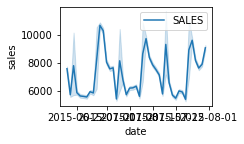

In [90]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'],df9['error'])

# 10.0 Deploy Model to Production

In [23]:
# Save trained model
#pickle.dump(model_xgb_tuned, open(r'C:\Users\jota_\Repositorios\DS producao\model_rossmann_final2.pkl', 'wb'))



## 10.1 Rosmann Class

In [24]:
import pandas as pd
import numpy as np
import math
import datetime as dtt
import pickle
import inflection

class Rossmann(object):
    def __init__(self):
        self.home_path = '/Users/jota_/Repositorios/DS_producao/'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))

      
    def data_cleaning(self, df1):
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        #Rename
        df1.columns = cols_new

        df1['date'] = pd.to_datetime(df1['date'])

        #competition_distance             
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month    

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                        else x['competition_open_since_month'], axis=1) 

        #competition_open_since_year     

        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                        else x['competition_open_since_year'], axis=1) 

        #promo2_since_week    
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                                        else x['promo2_since_week'], axis=1)

        #promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                                        else x['promo2_since_year'], axis=1)

        #promo_interval
        df1['promo_interval'].fillna(0, inplace=True)

        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
            lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        return df1
    
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since'] = df2.apply(lambda x: dtt.datetime(year=x['competition_open_since_year'],
                                                                         month=x['competition_open_since_month'],
                                                                         day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

        df2['promo_since'] = df2['promo_since'].apply(
            lambda x: dtt.datetime.strptime(x + '-1', '%Y-%W-%w') - dtt.timedelta(days = 7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(
            lambda x: 'public_holiday' if x == 'a' else 'easter' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        df2 = df2[df2['open'] != 0]
        
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):
        
        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # state_holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
        
        # store_type - Label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - ordinal encoding
        assortment_dict = {'basic': 1,
                         'extended': 3, 
                         'extra': 2}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2 * np.pi/12 )))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2 * np.pi/12 )))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2 * np.pi/30 )))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2 * np.pi/30 )))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi/52 )))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi/52 )))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi/7 )))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi/7 )))
        
        cols_selected = [
             'store',
             'promo',
             'store_type',
             'assortment',
             'competition_distance',
             'competition_open_since_month',
             'competition_open_since_year',
             'promo2',
             'promo2_since_week',
             'promo2_since_year',
             'competition_time_month',
             'promo_time_week',
             'month_cos',
             'month_sin',
             'day_sin',
             'day_cos',
             'week_of_year_cos',
             'week_of_year_sin',
             'day_of_week_sin',
             'day_of_week_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format='iso')
    
    
    
  



## 10.2 API Handler

In [25]:
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/Users/jota_/Repositorios/DS_producao/model_rossmann_final2.pkl', 'rb'))

# initialize api
app = Flask( __name__ )

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        
        if isinstance(test_json, dict): #unique exmple
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        #instantiate rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester 

In [26]:
#load test dataset
df10 = pd.read_csv('Datasets_ds/test.csv')

In [54]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction 
df_test = df_test[df_test['Store'].isin([15, 700])]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [55]:
#convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))


In [56]:
# API call
url = r'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [57]:
d1 = pd.DataFrame(r.json(),columns = r.json()[0].keys())

In [58]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,15,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,extended,4110.0,...,2015,9,17,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,8810.438477
1,700,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,830.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2013-07-01T00:00:00.000Z,115,5366.265137
2,15,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,extended,4110.0,...,2015,9,16,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,8778.179688
3,700,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,830.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2013-07-01T00:00:00.000Z,115,5485.519043
4,15,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,d,extended,4110.0,...,2015,9,15,38,2015-37,2010-03-01T00:00:00.000Z,67,2011-03-28T00:00:00.000Z,233,9644.168945


In [59]:
d2 =d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction']))

Store Number 15 will sell R$323,999.35 in the next 6 weeks
Store Number 700 will sell R$206,314.25 in the next 6 weeks


In [53]:
d2

,store,prediction
0,15,256221.31543
